# Predicting Pet Insurance Claims - Exploratory Data Analysis

## 1 Introduction

### 1.1 Background
Whenever a pet insurance policy holder incurs veterinary expenses related to their enrolled pet, they can submit claims for reimbursement, and the insurance company reimburses eligible expenses. To price insurance products correctly, the insurance company needs to have a good idea of the amount their policy holders are likely to claim in the future. 

### 1.2 Project Goal
The goal of this project is to create a machine learning model to predict how much (in dollars) a given policy holder will claim for during the second year of their policy. 

### 1.3 Initial Questions for EDA
Below are a few initial questions to answer and areas of interest for the detailed data analysis.
* What patterns or relationships exist between species and our other features?
* What is the distribution of our claims amounts by year? By breed? By species? By Age?
* Does enroll path matter when it comes to claims amounts?

Let's get started by importing the data we cleaned up in the data wrangling notebook.

## 2 Setup

### 2.1 Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

### 2.2 Data Load & Preview

In [3]:
# Read in the data file generated during data wrangling
df = pd.read_csv('../data/merged_pets.csv')

# Preview
df.head(7).T

,0,1,2,3,4,5,6
PetId,0,1,2,3,4,5,6
Species,Dog,Dog,Dog,Dog,Dog,Dog,Cat
Breed,Schnauzer Standard,Yorkiepoo,Mixed Breed Medium,Labrador Retriever,French Bulldog,Shih Tzu,American Shorthair
Premium,84.54,50.33,74.0,57.54,60.69,43.53,47.4
Deductible,200,500,500,500,700,700,250
EnrollPath,Web,Phone,Phone,Phone,Web,Phone,Web
AgeYr1,3,0,0,0,0,2,0
YoungAge,0,0,0,0,0,0,0
MixedBreed,0,0,1,0,0,0,0
AmtClaimsYr1,0.0,0.0,640.63,0.0,7212.25,2665.67,0.0


In [4]:
df.shape

(50000, 18)

### 2.3 Data Wrangling Summary 
Before we get started on the analysis, let's take a moment to recap what we've learned so far and what the data looks like.

#### 2.3.1 What do we know? 
* **Shape** - Our clean dataframe is 50000 rows with each row corresponding to a single pet.
* **Basic Info** - For each pet, we have some basic info including species, breed, age at time of enrollment and enroll path.
* **Policy Info** - We also have policy-level info for each pet including the monthly premium and deductible amount for claims.
* **Claims Data** - We also have claims data for each pet covering the first two policy years including:
    * Number of claims per year and total (years 1 and 2 combined)
    * Average claim amount per year and total (years 1 and 2 combined) 
    * Amount of claims per year and total (years 1 and 2 combined)
* **New Columns** - Finally, we have a couple of columns we generated during data wrangling to capture specific aspects of the data. These include:
    * YoungAge - Designation for pets who enrolled at a very young age (< 7 weeks)
    * MixedBreed - Designation for pets classified as some sort of *mixed* breed

#### 2.3.2 Initial Observations
* **Species** - We have two species of pets, Cats and Dogs
* **Breed** - We have 373 unique breeds in total (55 cat and 318 dog)
* **Age** - The age range is between 0 (i.e., < 1 year) and 13
* **Premium** - Premiums fall into a wide range with a few outlier values close to \\$1000
* **Deductible** - Deductibles are fairly well distributed and appear to be stratified across a range of common values.
* **Claims** 
    * For cats and dogs, the median value for total number and total amount of claims is 0.
    * On the flip side, both species have some significant outliers in both categories (number and amount of claims)
    
Now that we have a bit more context, let's jump in to the analysis.

## 3 Data Analysis
As a first step, we'll look at our count of pets per species. With that as our jumping off point, we can start investigating the first question from the intro... What patterns or relationships exist between species and our other features?

### 3.1 What is the count of pets per species?

In [5]:
df.Species.value_counts()

Dog    41976
Cat     8024
Name: Species, dtype: int64

As observed in data wrangling, we have approximately 50,000 pets in our data, roughly 85% of which are dogs. The remaining 15% are cats, so that keeps things fairly simple as we only have two breeds to compare. 

**But why do we see such a big discrepency in the number of dogs vs. the number of cats?**

It could mean that dogs are a more popular option for a pet, or it could mean that dogs are more expensive to keep healthy and insurance is needed. Intuitively, that should mean that dog owners have higher total claims amounts or a higher number of claims than cat owners on a per pet basis. 

Let's take a look.

### 3.2 Do dogs have higher claims or more claims than cats?
Based on what we observed in data wrangling, we know there are some very significant outliers in terms of claims amounts that will affect the interpretability of our plots. Let's filter down to a smaller range and take a look at the data.

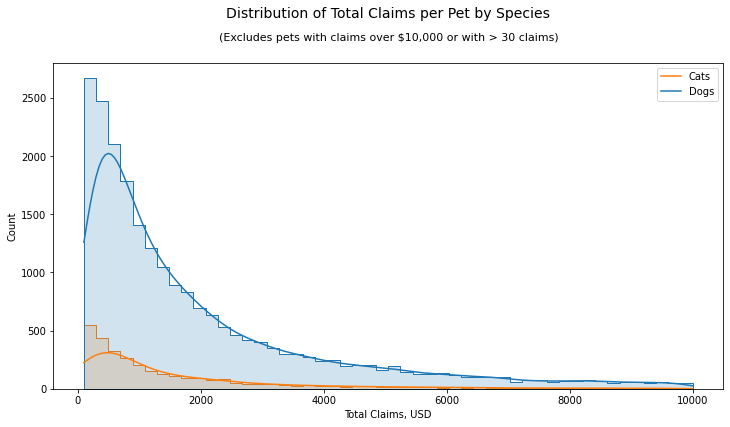

In [30]:
# Filter out outliers for number of claims and claim amounts
claim_filter = df[(df.AmtClaimsTotal < 10000) & (df.AmtClaimsTotal > 100) &
                 (df.NumClaimsTotal < 30) & (df.NumClaimsTotal > 0)]

# Create a histogram showing total claims by species
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(x="AmtClaimsTotal", data=claim_filter, hue='Species', alpha=0.2,
             element='step', kde=True, bins=50).set(title="Distribution of Total Claims, by Species",
                                          xlabel="Total Claims, USD")

# Plot legend and display
plt.title("Distribution of Total Claims per Pet by Species", y=1.12, fontsize=14)
plt.suptitle("(Excludes pets with claims over $10,000 or with > 30 claims)", y=0.95, x=0.513, fontsize=11)
plt.legend(labels=(['Cats', 'Dogs']), loc='upper right')
plt.show()

The distributions for claims amounts per pet look somewhat similar, both spike on the low end and have long tails to the right. It does appear that the distribution for dogs is shifted somewhat further to the right overall but difficult to tell in this view.

Let's see if the number of claims is any different.

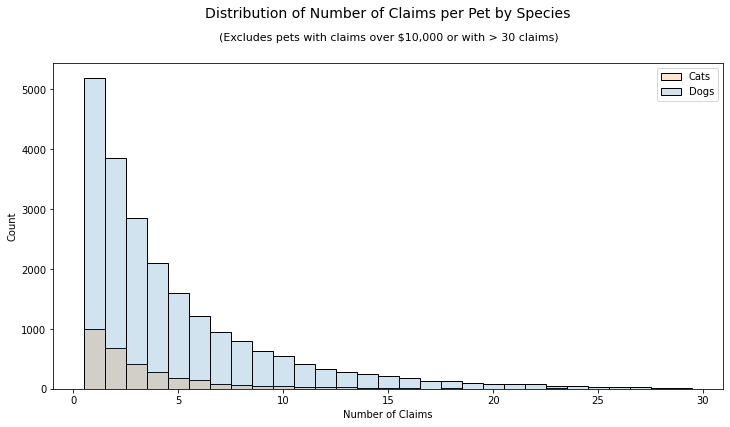

In [28]:
# Create a histogram showing number of claims per pet by species
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(x="NumClaimsTotal", data=claim_filter, hue='Species', alpha=0.2,
             element='bars', bins=30, discrete=True).set(xlabel="Number of Claims")

# Plot legend and display
plt.title("Distribution of Number of Claims per Pet by Species", y=1.12, fontsize=14)
plt.suptitle("(Excludes pets with claims over $10,000 or with > 30 claims)", y=0.95, x=0.513, fontsize=11)
plt.legend(labels=(['Cats', 'Dogs']), loc='upper right')
plt.show()

Again, there doesn't seem to be an obvious story in the plot above and it's hard to see much difference in species when it comes to claims. Let's try one more plot before moving on to see  

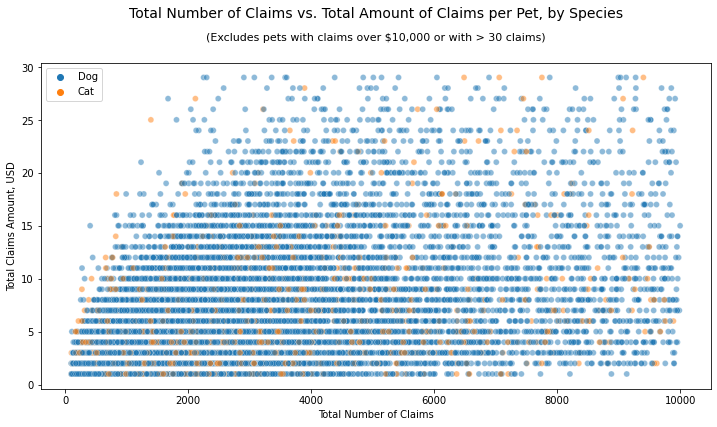

In [27]:
# Create a scatterplot showing Number of Claims vs Amount of Claims per pet by species
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.scatterplot(x="AmtClaimsTotal", y="NumClaimsTotal", data=claim_filter, hue="Species", 
                alpha=0.5).set(title="",
                               ylabel="Total Claims Amount, USD", xlabel="Total Number of Claims")

# Plot legend, add title, and display
plt.title("Total Number of Claims vs. Total Amount of Claims per Pet, by Species", y=1.12, fontsize=14)
plt.suptitle("(Excludes pets with claims over $10,000 or with > 30 claims)", y=0.95, x=0.513, fontsize=11)
plt.legend(loc='upper left')
plt.show()

The scatterplot is still inconclusive when grouping the species together. Let's try separating Cats and Dogs and adding a regression line to the data as a next step.

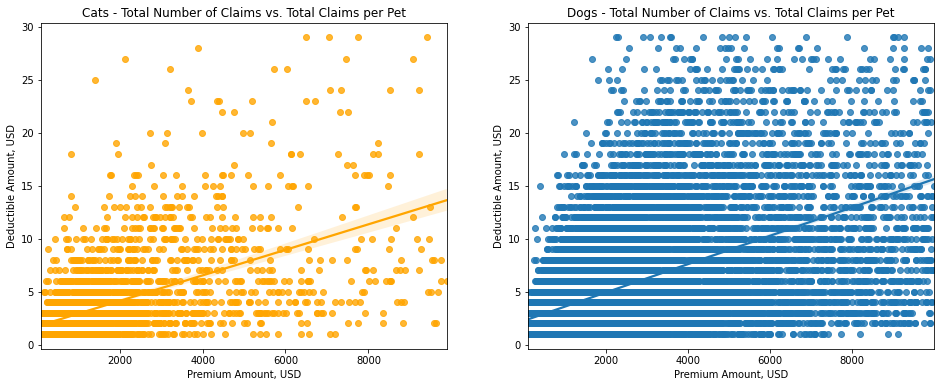

In [33]:
# Create a scatterplot showing deductible vs premium amounts by species
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.regplot(x="AmtClaimsTotal", y="NumClaimsTotal", data=claim_filter[claim_filter.Species == 'Cat'],  
                ax=ax1, color="Orange"
                ).set(title="Cats - Total Number of Claims vs. Total Claims per Pet",
                     ylabel="Deductible Amount, USD", xlabel="Premium Amount, USD")
sns.regplot(x="AmtClaimsTotal", y="NumClaimsTotal", data=claim_filter[claim_filter.Species == 'Dog'],  
                ax=ax2).set(title="Dogs - Total Number of Claims vs. Total Claims per Pet", 
                                       ylabel="Deductible Amount, USD", xlabel="Premium Amount, USD")

plt.show()

Interesting! We still don't see much difference in species when it comes to total amount of claims or total number of claims per pet. Based on this alone, we could make a case that dropping species from the data makes sense. But before we go that far, let's take a look at Premiums and Deductibles across species.  

**Conclusion**

Species does not appear to be a factor in predicting claims amounts.

### 3.3 Do dogs cost more to insure?

So our initial hypothesis - that dogs have higher claims amounts or more claims than cats - does not appear to be the case (at least not in a significant way). Based on this, we would expect to see similar premiums and deductibles across our species, but is that the case?

In data wrangling, we observed some pets with very high premiums that will undoubtedly skew our analysis. Let's start by filtering down to a smaller range and then take a look at our distributions.

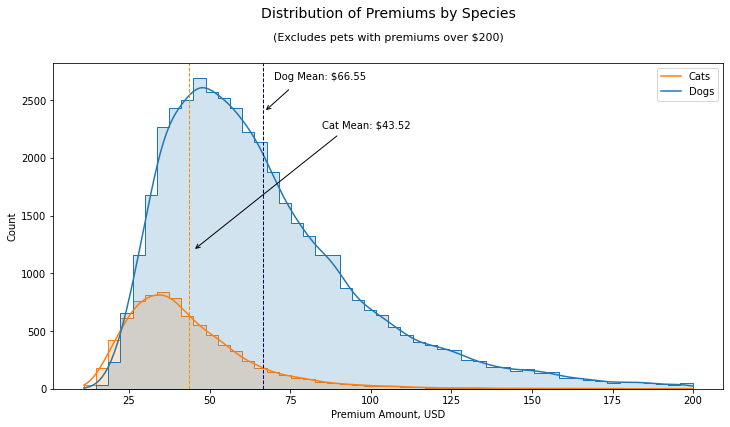

In [37]:
# Filter out the outlier premiums
prem_filter = df[df.Premium < 200][['Premium', 'Deductible', 'Species', 'AgeYr1']]
dog_mean = prem_filter[prem_filter.Species == 'Dog']['Premium'].mean()
cat_mean = prem_filter[prem_filter.Species == 'Cat']['Premium'].mean()

# Create a histogram showing premium amounts by species
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(x="Premium", data=prem_filter, hue="Species", alpha=0.2,
             element='step', bins=50, kde=True).set(title="", xlabel="Premium Amount, USD")

# Plot mean premium amount for dogs and cats
plt.axvline(cat_mean, color='darkorange', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(cat_mean*1.95, max_ylim*0.8, 'Cat Mean: ${:.2f}'.format(cat_mean))
ax.annotate("", xy=(45, 1200), xytext=(90, 2200), arrowprops=dict(arrowstyle="->"))

plt.axvline(dog_mean, color='darkblue', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(dog_mean*1.05, max_ylim*0.95, 'Dog Mean: ${:.2f}'.format(dog_mean))
ax.annotate("", xy=(67, 2400), xytext=(75, 2600), arrowprops=dict(arrowstyle="->"))

# Add title and display clot
plt.title("Distribution of Premiums by Species", y=1.12, fontsize=14)
plt.suptitle("(Excludes pets with premiums over $200)", y=0.95, x=0.513, fontsize=11)
plt.legend(labels=(['Cats', 'Dogs']), loc='upper right')
plt.show()

Once again, looking at the premium distribution curves we see similar trends for both species but with dogs shifted further to the right. By adding the mean premium values, it's clear that dog owners do pay higher premiums *on average* when compared to cats. 

How does this trend affect deductible amounts? If dog owners pay higher premiums, then potentially they should have lower deductibles. Rather than plotting a distribution, let's look at a scatterplot of Premium vs. Deductible to see if any noticeable trends stand out.

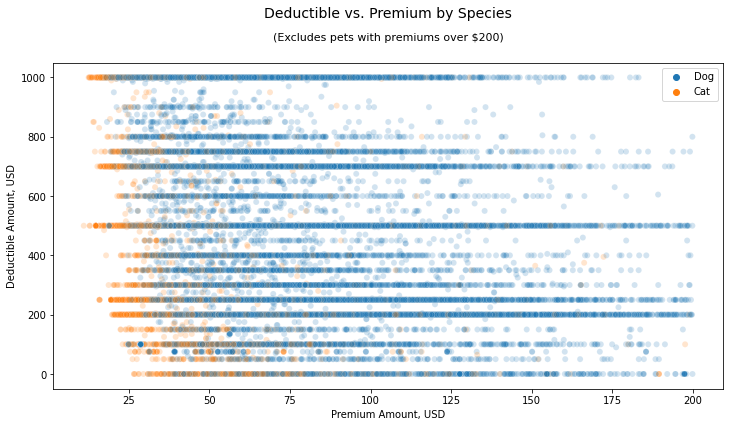

In [39]:
# Create a scatterplot showing deductible vs premium amounts by species
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.scatterplot(y="Deductible", x="Premium", data=prem_filter, hue="Species", 
                alpha=0.2).set(title="", ylabel="Deductible Amount, USD", xlabel="Premium Amount, USD")

# Add title and display plot
plt.title("Deductible vs. Premium by Species", y=1.12, fontsize=14)
plt.suptitle("(Excludes pets with premiums over $200)", y=0.95, x=0.513, fontsize=11)
plt.legend(loc='upper right')
plt.show()

In [40]:
# Display the mean deductible per species
dog_mean = df[df.Species == 'Dog']['Deductible'].mean()
cat_mean = df[df.Species == 'Cat']['Deductible'].mean()
print("Mean Deductible Amounts by Species (full dataset)")
print('Cat Mean Deductible: ${:.2f}'.format(cat_mean))
print('Dog Mean Deductible: ${:.2f}'.format(dog_mean))

Mean Deductible Amounts by Species (full dataset)
Cat Mean Deductible: $433.97
Dog Mean Deductible: $506.69


For deductible, we see a similar striation of the data for both dogs and cats at round number values (250, 500, 750), but it seems clear that cats tend to be bunched on the low end of the spectrum across the range. This trend is confirmed by looking at the mean values for our unfiltered dataframe where we see that dogs do have higher deductibles by ~\\$75 on average. So we are starting to see a picture here that *generally*, dogs are more expensive than cats (at least when it comes to insurance payments). 

**Conclusions**

* Dogs and cats both have a broad range of premiums and deductibles with similar distributions for each 
* On average, dogs have higher premiums and higher deductibles than cats

### 3.4 How many pets have claims in one or both years?
So far in EDA, we've seen that there isn't much of a difference in the distributions of the total number of claims across species. We've also observed both in EDA and data wrangling, that a significant number of pets have no claims at all within the first two years. 

**But what trends do we see for pets with claims in one or both years?** 
* Do the majority have claims in both years or only one year? 
* Additionally, are there any patterns that jump out when we look at pets with claims in both years in terms of species or age?

First, let's create a basic function to determine for each pet, if they have no claims, claims in one year (either year 1 or year 2), or claims in both years. Then we can plot our results to see if anything interesting jumps out.

In [41]:
# Create function to populate new column as count of number of years with claims (0, 1, 2)
def claim_yrs(row):
    if (row["NumClaimsTotal"] == 0):
        return 0
    elif ((row["NumClaimsYr1"] > 0) & (row["NumClaimsYr2"] > 0)):
        return 2
    else:
        return 1

# Apply function to df to create new column
df["YrsWithClaims"] = df.apply(claim_yrs, axis=1)

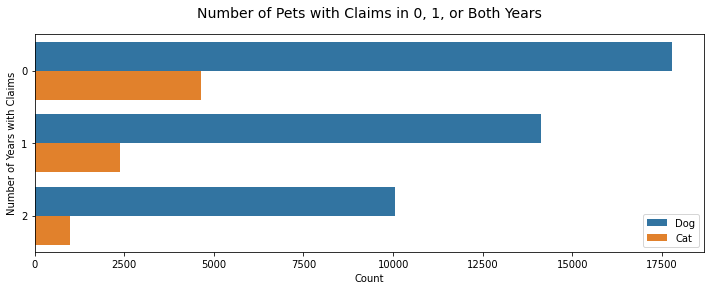

In [47]:
# Plot the count of pets with claims in 0, 1 or both years
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.countplot(y='YrsWithClaims', data=df, hue="Species").set(xlabel="Count",
                                                             ylabel="Number of Years with Claims")

# Add title and display plot
plt.title("Number of Pets with Claims in 0, 1, or Both Years", y=1.05, fontsize=14)
# plt.suptitle("(Excludes pets with premiums over $200)", y=0.95, x=0.513, fontsize=11)
plt.legend(loc='lower right')
plt.show()

As noted earlier, the majority of pets in our data (and for each species) have no claims at all in the two years included in the dataset. Again, we see similar looking trends between species in terms of the counts at 0, 1 and 2 years, but it's hard to make out any differences since the dataset is unbalanced toward dogs by nearly 6 to 1. 

Let's see if plotting this based on the percentage of each species with claims in 0, 1 or 2 years highlights any differences. 

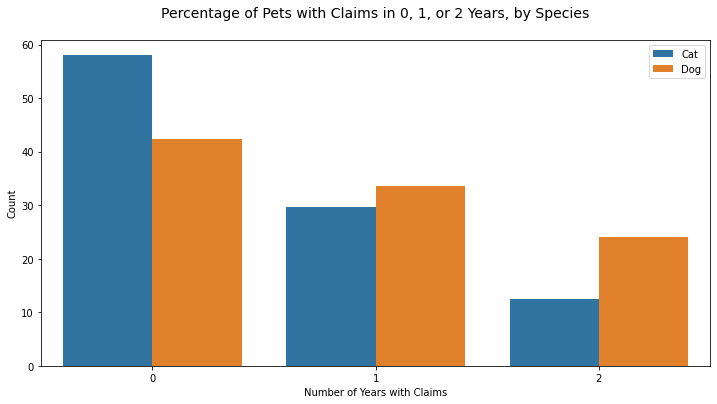

In [49]:
# Calculate the percentage of each species with claims in 0,1, or 2 years
claim_yr_counts = (df.groupby(['Species'])['YrsWithClaims']
                     .value_counts(normalize=True)
                     .rename('Percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('YrsWithClaims'))

# Plot the data 
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.barplot(x="YrsWithClaims", y="Percentage", hue="Species", data=claim_yr_counts 
           ).set(xlabel="Number of Years with Claims", ylabel="Count")

# Plot the legend and display
plt.title("Percentage of Pets with Claims in 0, 1, or 2 Years, by Species", y=1.05, fontsize=14)
plt.legend(loc='upper right')
plt.show()

By plotting the percentages of each species with claims in zero, one, or both years, we see a somewhat unexpected result. Dogs are less likely to have claims overall and cats are more likely to have claims in one or both policy years.

So this is adds more support to the idea that there are some differences in species and it's likely not something we want to drop. It will be interesting to revisit the data on number of years with claims later as we get into breed analysis. For now, we can draw a couple of basic conclusions and move on.

**Conclusions**
* Around one half of pets in both species have no claims at all
* Based on percentages of each species, cats are more likely to have claims in one or both years.

### 3.5 Do insurance claims rise with age?
On the surface, this feels like the most obvious question in the world and maybe we should just answer "Yes" and move on with our lives. But then again, it's probably worth a look to see if our intuition holds.

To start with, let's take a very basic, high level look at average total claims per pet by age. No species breakdown yet, let's just try and discern whether age matters at all when it comes to claims amounts.

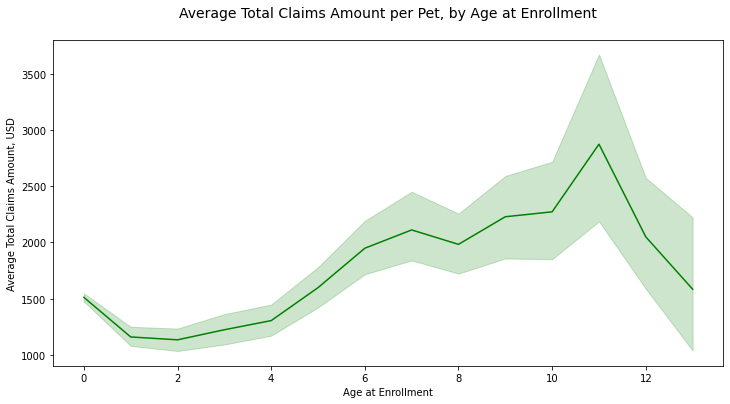

In [55]:
# Create a line plot showing total claims by Age
f, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.lineplot(x="AgeYr1", y="AmtClaimsTotal", data=df,
             color="Green", ci=95).set(xlabel="Age at Enrollment", ylabel="Average Total Claims Amount, USD")
plt.title("Average Total Claims Amount per Pet, by Age at Enrollment", y=1.05, fontsize=14)
plt.show()

# Update with observations - Start Here

In [ ]:
# Create a violin plot showing distribution of total claims based on year of enrollment
f, ax = plt.subplots(1, 1, figsize=(16, 6))
sns.violinplot(x="AgeYr1", y="AmtClaimsTotal", data=claim_filter,
               color="LightGreen").set(xlabel="Age at Enrollment", ylabel="Total Claims Amount, USD")
plt.title("Distribution of Total Claims Amount, by Age at Enrollment", y=1.12, fontsize=14)
plt.suptitle("(Excludes pets with claims over $10,000 or with > 30 claims)", y=0.95, x=0.513)
plt.show()

At a high level, the violin plot shows the distribution of total claims amounts changing with age. As age increases, we see the spread of total claims amounts increasing as well. That said, the details of the distribution are tough to make out in this view and it's tough to know if there is anything significant going on or not.

Let's try one more plot before drawing final conclusions about age.

In [ ]:
# Filter out outliers for number of claims and claim amounts
claim_filter_low = df[(df.AmtClaimsTotal < 6000) & (df.AmtClaimsTotal > 100) &
                 (df.NumClaimsTotal < 30) & (df.NumClaimsTotal > 0)]

# Create a box plot showing claims amounts by age
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.boxplot(x='AgeYr1', y='AmtClaimsTotal', data=claim_filter_low, color="Green",
            ).set(ylabel="Total Claims Amount, USD", xlabel="Age at Enrollment")

plt.title("Distribution of Total Claims Amount per Pet by Age of Enrollment", y=1.12, fontsize=14)
plt.suptitle("(Excludes pets with total claims over $6000)", y=0.95, x=0.513)
plt.show()

In [ ]:
# Plot the ecdf of total claims by pet age at enrollment
g = sns.displot(claim_filter, x="AmtClaimsTotal", col="AgeYr1", col_wrap=7, hue="Species",
                kind="ecdf", height=1.8, legend=False) 
g.set_axis_labels("", "");

plt.title("Cumulative Distribution of Total Claims Amount per Pet by Age of Enrollment", y=3, x=-3, fontsize=14)
plt.suptitle("(Excludes pets with total claims over $6000)", y=1.08, x=0.513)
g.fig.legend(labels=['Dogs', 'Cats'], bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.show()

# Update observations
Interesting! So while we might expect to see a much greater range of claims at the top end of the age spectrum, this does not match up with the data. In fact, we see the highest claims amounts in the youngest category of pets. We do still see evidence that the variability of total claims amounts increases with age, but it's less pronounced when we factor in the outlier values.

**Summary**
* Total claims amounts tend to rise with age, to a point at least
* The variability of total claims amounts also rises with age
* Even very young pets can have significantly high values for total claims

**Conclusion:**
* Age matters when it comes to claims amounts, but it doesn't seem to follow a straighforward linear trajectory.

Next, let's take a look at enroll path to determine if this matters at all for our analysis.

### 3.4 Does enroll path tell us anything about pet claims?
Intuitively, it's probably safe to say no. But it could be the case that enroll path tells us something about the pet owners that translates into more or fewer claims. Let's start by looking at a count of pets in each category.

In [ ]:
df.EnrollPath.value_counts()

It looks like we have 3 possibilities, Web, Phone and EB. It's unclear what "EB" stands for, but luckliy that is a pretty small percentage of our data. The majority of pets were enrolled by either Web or Phone.

Since claims amounts are the focus of this project, let's see if there is any noticeable difference in the distributions of number or amount of claims related to enroll path. If not, it's probably safe for us to drop this column.

In [ ]:
# Create box plots showing distribution of number and amount of claims by enroll path
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x="EnrollPath", y="NumClaimsTotal", data=df, ax=ax1,
            sym="").set(title = "Number of Claims per Pet", xlabel="", ylabel="")
sns.boxplot(x="EnrollPath", y="AmtClaimsTotal", data=df, ax=ax2,
            sym="").set(title = "Total Amount of Claims per Pet", xlabel="", ylabel="")

plt.suptitle("Distribution of Claims per Pet by Enroll Path", y=1.05, fontsize=14)
plt.show()

The distributions look very similar for all enroll paths which supports our original assertion that enroll path shouldn't have any significant impact on number or amount of claims.

Before moving on, let's look at a scatterplot for each and add a regression line. 

In [ ]:
# Plot a regression model for each enroll path showing number of claims vs. amount of claims
g = sns.lmplot(x="NumClaimsTotal", y="AmtClaimsTotal", col="EnrollPath", hue="EnrollPath", data=claim_filter,
           ci=None, palette="muted", height=4, scatter_kws={"s": 50, "alpha": 0.2})
g.set_axis_labels("Total Number of Claims", "Total Amount of Claims, USD");

plt.suptitle("Number of Claims vs. Amount of Claims per Pet by Enroll Path", y=1.07, fontsize=14)
plt.show()

Adding the regression lines is a bit more helpful as we can see a similar trend across all three categories. For EB though, there's so little data that it's hard to trust the regression line especially as we get further out into the outliers.

While we do see some slight variation in the plots above, it doesn't seem to be significant enough to draw the conclusion that enroll path has an affect on number or amount of claims. Given this, we'll drop that column and move on.

In [ ]:
# Drop EnrollPath
df = df.drop(columns=["EnrollPath"])

# DRAFT ONLY BELOW
## 3.7 How does breed factor in to total claims amounts?

* Does it make sense to look at the proportion of a breed with high claims and see if any of the breeds stand out?
* Should I only pay attention to this is the breeds in question have a count of pets higher than some significant number (e.g., 30)?

### Cat breeds
Since we only have ~35 total cat breeds, we can take a quick look at a rollup of claims data for all breeds to help guide next steps.

In [ ]:
# # Group cats by breed and aggregate claims data columns
# cats_by_breed = cats.groupby('Breed').agg({'PetId': ['count'],
#                                            'NumClaimsYr1':['mean'],
#                                            'NumClaimsYr2':['mean'],
#                                            'AmtClaimsYr1':['mean', 'median', 'min', 'max'], 
#                                            'AmtClaimsYr2':['mean', 'median', 'min', 'max']}
#                                          )
# # View result
# cats_by_breed

### Initial observations on cat breeds
* The number of cats for each breed covers a wide range, from 1 pet for certain breeds to 3511 for the most common breed. 
* Some breeds with a low count have 0 claims (e.g., American Wirehair and Chartreux), while others have very high claims (e.g., Selkirk Rex). 
* The most common values for median and minimum claims amounts is \\$0. This matches up with what we observed earlier on in the analysis and will likely factor in to the final predictions.

TODO for conclusions - will need to pick a count that is reasonable and then group breeds below that count into an "Other" category.

In [ ]:
# Preview number of cat breeds with a count of pets greater than 30
# cats_by_breed[cats_by_breed['PetId']['count'] >= 30]['PetId']['count'].sort_values(ascending=False)

In [ ]:
# Preview full result
# cats_by_breed[cats_by_breed['PetId']['count'] >= 30].sort_values([('AmtClaimsYr2', 'mean')], ascending=False)

In [ ]:
# # Preserve list of Breeds with count greater equal to 30
# cat_breeds = cats_by_breed[cats_by_breed['PetId']['count'] >= 30].index.to_list()

# # cats_by_breed.reset_index(inplace=True)

# # Group breeds as 'Other' if count less than 30

In [ ]:
# x = cats_by_breed[cats_by_breed['PetId']['count'] >= 30].index
# y1 = cats_by_breed[cats_by_breed['PetId']['count'] >= 30][('AmtClaimsYr1', 'mean')]
# y2 = cats_by_breed[cats_by_breed['PetId']['count'] >= 30][('AmtClaimsYr2', 'mean')]

# plt.figure(figsize=(10,6))
# # _ = plt.barh([y1,y2], stacked=True, width=1.0)
# cats_by_breed[cats_by_breed['PetId']['count'] >= 30][[('AmtClaimsYr1', 'mean'),('AmtClaimsYr2', 'mean')]].plot(kind='barh', stacked=True)

# plt.gca().invert_yaxis()
# plt.show()

In [ ]:
###########
# TODO
##########
# View distribution of average claims by cat breed (below seems like it would work for dogs as well)
## Maybe a scatter plot - each breed is a point plotted based on avg total num claims and avg total amount claims 
## Scatter plot circle size based on count of breed
# Group cat breeds with fewer than 20 or 30 representative cats (unless it seems there is a significant difference maybe?? how to do this?)

In [ ]:
# breed_counts = cats_by_breed['NumClaimsTotal', 'count']
# breed_num_claims = cats_by_breed['NumClaimsTotal', 'mean']
# breed_amt_claims = cats_by_breed['AmtClaimsTotal', 'mean']

# plt.figure(figsize=(10,6))
# _ = sns.scatterplot(data=cats_by_breed, x=breed_num_claims, y=breed_amt_claims, 
#                     size=breed_counts, sizes=(20, 200), legend=False)
# plt.show()

In [ ]:
# cats_by_breed = cats_by_breed[cats_by_breed['AmtClaimsTotal', 'mean'] < 2000]

In [ ]:
# breed_counts = cats_by_breed['NumClaimsTotal', 'count']
# breed_num_claims = cats_by_breed['NumClaimsTotal', 'mean']
# breed_amt_claims = cats_by_breed['AmtClaimsTotal', 'mean']

# plt.figure(figsize=(10,6))
# _ = sns.scatterplot(data=cats_by_breed, x=breed_num_claims, y=breed_amt_claims, 
#                     hue=breed_counts, size=breed_counts, sizes=(20, 200), legend=True)

# plt.xlabel('Avg Total Number of Claims')
# plt.ylabel('Avg Total Amount of Claims')
# plt.title('Average Claims by Breed')
# # _._legend.set_title('Count of Breed')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5, title="Count of Breed")

# plt.show()

### 3.8 Is there any significant correlation between claims in year 2 and our other features?

TODO - Explain why I am filtering down to a subset of features

In [ ]:
cats = filtered_df[filtered_df.Species == 'Cat']
dogs = filtered_df[filtered_df.Species == 'Dog']

# Filter species dfs down the a subset of features
cols = ['Premium', 'Deductible', 'AgeYr1', 'YoungAge', 'MixedBreed', 'AmtClaimsYr1',
             'AvgClaimsYr1', 'NumClaimsYr1', 'AmtClaimsYr2']
cats_filtered = cats[cols]
dogs_filtered = dogs[cols]

In [ ]:
# Create correlation matrices
cats_corr = cats_filtered.corr()
dogs_corr = dogs_filtered.corr()

# Plot the corresponding heatmaps
plt.figure(figsize=(10,6))
_ = sns.heatmap(dogs_corr, cmap="Blues")
plt.show()

plt.figure(figsize=(10,6))
_ = sns.heatmap(cats_corr, cmap="YlOrBr")
plt.show()

## TODO
* Conclusions about correlation matrix
* Overall summary of and key takeaways
* Clean up data for next step and write to new file
* Initial thoughts about pre-processing and/or predictive model

## 4 Summary and Conclusions
